<a href="https://colab.research.google.com/github/hcgalvan/labodedatos/blob/main/PCA_INDIVIDUO_UNICO_Amalia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
RANDOM_SEED = 1
random.seed(a=RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats
import pandas as pd
import seaborn as sns
import time
from matplotlib.colors import ListedColormap
# definición de pipelines
from sklearn.pipeline import Pipeline
# feature selection and model
from sklearn.linear_model import LogisticRegression
# selección de modelos
from sklearn.model_selection import train_test_split
# normalización de datos
from sklearn.preprocessing import StandardScaler
# funciones para construir datasets sintéticos
from sklearn.datasets import make_moons, make_circles, make_classification
# clasificador: red neuronal (perceptron multicapa, 100 capas por defecto, activación por ReLu)
from sklearn.neural_network import MLPClassifier
# clasificador: KNN
from sklearn.neighbors import KNeighborsClassifier
# clasificador: support vector classifier
from sklearn.svm import SVC
# clasificador: árbol de decisión
from sklearn.tree import DecisionTreeClassifier
# clasificador: ensemble de árboles (random forest)
from sklearn.ensemble import RandomForestClassifier
# clasificador: árbol de decisión
from sklearn.model_selection import StratifiedKFold
# Modulos específicos para árboles de decisión
from sklearn.tree import plot_tree # Función para visualizar el árbol
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Clasificador: red neuronal (percepton multicapa, 100 capas por defecto, activaciòn por ReLu
from sklearn.neural_network import MLPClassifier

In [ ]:
filename =  '/content/drive/MyDrive/Laboratorio de datos final/sujeto_A.csv'
filename1 =  '/content/drive/MyDrive/Laboratorio de datos final/sujeto_b.csv'
filename2 =  '/content/drive/MyDrive/Laboratorio de datos final/sujeto_c.csv'
filename3 =  '/content/drive/MyDrive/Laboratorio de datos final/sujeto_d.csv' # para mi prueba luego lo comentas y dejas el original

In [ ]:
df = pd.read_csv(filename)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()

Cantidad de samples: 683
Cantidad de features: 989


lag1_mean_0  lag1_mean_1  lag1_mean_2  ...  freq_740_3  freq_750_3  Label
0    21.623625    24.124145   129.285820  ...    0.001898    0.001086    2.0
1    21.736117    28.079977    12.916582  ...    0.015894    0.005789    1.0
2    34.675582    34.200645   -57.624820  ...    0.001038    0.001973    2.0
3    40.359480    33.828742   -72.202695  ...    0.004311    0.004528    2.0
4    24.444455    32.847860    14.215233  ...    0.009827    0.002551    1.0

[5 rows x 989 columns]

In [ ]:
# Con esta forma quitamos el ultimo feature 'Label'
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print("Cantidad de datos del lote de entrenamiento: {}\nCantidad de datos del lote de testing: {}".format(X_train_set.shape[0], X_test.shape[1]))

Cantidad de datos del lote de entrenamiento: 546
Cantidad de datos del lote de testing: 988


In [ ]:
# Dataset de entranamiento completo
df_train = pd.concat([X_train_set, y_train_set], axis=1)

In [ ]:
df_train.columns

Index(['lag1_mean_0', 'lag1_mean_1', 'lag1_mean_2', 'lag1_mean_3',
       'lag1_mean_d_h2h1_0', 'lag1_mean_d_h2h1_1', 'lag1_mean_d_h2h1_2',
       'lag1_mean_d_h2h1_3', 'lag1_mean_q1_0', 'lag1_mean_q1_1',
       ...
       'freq_669_3', 'freq_679_3', 'freq_689_3', 'freq_699_3', 'freq_709_3',
       'freq_720_3', 'freq_730_3', 'freq_740_3', 'freq_750_3', 'Label'],
      dtype='object', length=989)

In [ ]:
'''
  Select feature whose correlation with target is greater than cut.
  Absolute: True to consider asbolute values. Default: False
  Plot: to show a veryn simple plot
  Return: Highest K best correlated features and their values as Series
'''
def select_k_best_correlated_features(df, cut, corr_method='pearson', absolute=False, plot=False):
  sns.set(rc={'figure.figsize':(10.7,8.27)})
  corr = df.corr(method=corr_method)['Label']  #Si dejamos el Label funcionará
  corr = corr.drop(corr.index[-1])
  if absolute: corr = abs(corr)
  selected_features = corr[corr > cut]
  if plot: corr.sort_values().plot(ylabel='Correlation')
  return selected_features


In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
# Clase para realizar componentes principales
from sklearn.decomposition import PCA

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [ ]:
X = X_train_set
# Ajustamos el estandarizador
std_scale.fit(X) #falta obtener X
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X)

In [ ]:
# Creación del modelo de PCA con todas las componentes
pca = PCA(n_components = None)

In [ ]:
# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)

print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)

Dimensiones de la matriz en componentes principales: (546, 546)
[[-1.72162534e+01 -5.51741511e+00  1.30324104e+00 ... -2.43202961e-01
   3.53584272e-01 -6.93889390e-16]
 [-4.08643468e+00  1.18092138e+01  3.03701528e+00 ...  1.26533416e-01
   6.74396965e-02  1.03250741e-14]
 [ 4.53612535e+00 -3.26351227e+00 -5.21206529e+00 ... -8.41987052e-03
   9.02157614e-02 -4.74620343e-15]
 ...
 [ 1.56806556e+01  2.80653012e+00  7.03287143e+00 ... -8.87852135e-03
   8.51640605e-02  9.99200722e-16]
 [ 8.20730453e+00  3.82095021e+00 -6.96383989e+00 ... -4.60679232e-02
  -1.19947791e-01  3.60822483e-15]
 [ 2.19046694e+01  2.15885345e+00  9.64978792e+00 ...  5.87130892e-02
  -1.04212394e-01  1.99840144e-15]]


Text(0.5, 0, 'Cantidad de componentes principales')

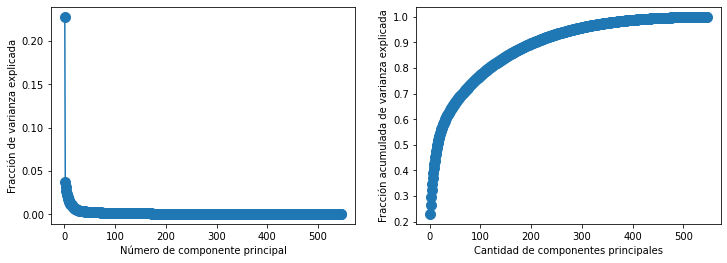

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

In [ ]:
# Importemos por ejemplo el modelo de regresión lineal
from sklearn.linear_model import LinearRegression

# Fijamos la variable 
y = df_train
print(df_train.shape, y.shape) # tenemos que ver si

# Escaleamos nuestras variables
std_scale.fit(X_train_set)
X_scaled = std_scale.transform(X)

# Describimos nuestros datos en el espacio 2D de componentes principales
pca = PCA(n_components = 150)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# Creamos el modelo 
reg = LinearRegression()

# Ajustamos con la matriz de nuestros datos en componentes principales
reg.fit(X_pca, y) #tienen diferencias en xamples, porque no se de donde viene X, allí hay que buscar.

(546, 989) (546, 989)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Modelo SVC

In [ ]:
# import some data to play with
def grafics(df1):
 X1 = df1.iloc[:,:6].values  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
 h = .02  # step size in the mesh

 # we create an instance of SVM and fit out data. We do not scale our
 # data since we want to plot the support vectors
 C = 1.0  # SVM regularization parameter
 svc = SVC(kernel='linear', C=C).fit(X1, y)
 rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X1, y)
 poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X1, y)

 # create a mesh to plot in
 x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
 y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
 xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

 # title for the plots
 titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


 for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()
#@njit(fastmath=True, cache=True)

In [ ]:
# Función que devuelve Score en SVC Lineal y SVC Gamma
def Support_Vector_Classifier (X, y, c1, c2):
  clfSVCL = SVC(kernel="linear", C=c1, probability=True)
  clfSVCL.fit(X, y) # entreno
  score_svcl = clfSVCL.score(X_test, y_test) # evaluo
 
  clfSVCG = SVC(gamma=2, C=c2, probability=True)
  clfSVCG.fit(X_train, y_train) # entreno
  score_svcg = clfSVCG.score(X_test, y_test) # evaluo
  print('score SVC Lineal:', score_svcl,', score SVC Gama:', score_svcg)

In [ ]:
X = df_train
print(X.count)
y = df_train['Label']

<bound method DataFrame.count of      lag1_mean_0  lag1_mean_1  lag1_mean_2  ...  freq_740_3  freq_750_3  Label
439    15.069980    40.658953    53.096797  ...    0.003374    0.001720    2.0
286    27.276965    28.869625    28.553035  ...    0.004569    0.005911    1.0
546    24.764996    27.250289    23.519523  ...    0.005731    0.006359    0.0
299    25.135035    35.316500  -192.665090  ...    0.001367    0.001017    2.0
256    26.063941    28.051371    26.355738  ...    0.015875    0.004734    1.0
..           ...          ...          ...  ...         ...         ...    ...
551     8.663172    20.397246    26.346227  ...    0.008770    0.013867    0.0
403    24.347313    27.894961    28.387047  ...    0.021768    0.016875    1.0
507    23.790367    23.151422    39.926504  ...    0.012296    0.027284    1.0
487    23.593891    18.650070    26.950863  ...    0.007993    0.014333    0.0
429    20.248434    16.609219    26.851680  ...    0.019347    0.018744    1.0

[546 rows x 989 co

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

(436, 989) (436,)


In [ ]:
# CLASIFICACIÓN: SVC CON PEARSON
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
Support_Vector_Classifier(X_train, y_train, 0.025, 1 )

score SVC Lineal: 0.9636363636363636 , score SVC Gama: 0.2909090909090909


In [ ]:
df_train = pd.concat([X, y], axis=1)
print(df_train.shape, y.shape)


(546, 990) (546,)


In [ ]:
#compruebo si hay diferencias
X_train.shape[0] != y.shape[0]

In [ ]:
# CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
print(len(X), len(y_train_set))
clfSVCL1 = SVC(kernel="linear", C=0.025, probability=True)
clfSVCL1.fit(X, y_train_set) # entreno
score_svcl = clfSVCL1.score(X_test, y_test) # evaluo
 
clfSVCG1 = SVC(gamma=2, C=0.025, probability=True)
clfSVCG1.fit(X, y_train_set) # entreno
score_svcg = clfSVCG1.score(X_test, y_test) # evaluo
print('score SVC Lineal:', score_svcl,', score SVC Gama:', score_svcg)

546 546
score SVC Lineal: 1.0 , score SVC Gama: 0.6909090909090909


Cantidad de samples: 683
Cantidad de features: 989
Cantidad de datos del lote de entrenamiento: 546
Cantidad de datos del lote de testing: 988
(546, 988) (546,) (137, 988) (137,)
Dimensiones de la matriz en componentes principales: (546, 546)
[[-1.72162534e+01 -5.51741511e+00  1.30324104e+00 ... -2.43202961e-01
   3.53584272e-01 -6.93889390e-16]
 [-4.08643468e+00  1.18092138e+01  3.03701528e+00 ...  1.26533416e-01
   6.74396965e-02  1.03250741e-14]
 [ 4.53612535e+00 -3.26351227e+00 -5.21206529e+00 ... -8.41987052e-03
   9.02157614e-02 -4.74620343e-15]
 ...
 [ 1.56806556e+01  2.80653012e+00  7.03287143e+00 ... -8.87852135e-03
   8.51640605e-02  9.99200722e-16]
 [ 8.20730453e+00  3.82095021e+00 -6.96383989e+00 ... -4.60679232e-02
  -1.19947791e-01  3.60822483e-15]
 [ 2.19046694e+01  2.15885345e+00  9.64978792e+00 ...  5.87130892e-02
  -1.04212394e-01  1.99840144e-15]]
Dimensiones de la matriz en componentes principales: (546, 988)
Dimensiones de la matriz en componentes principales: (137

Text(0, 0.5, 'Segunda componente principal')

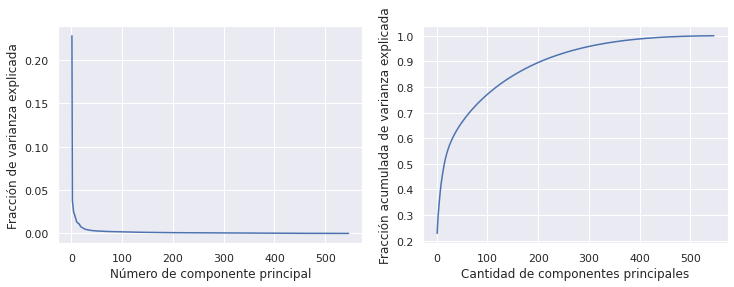

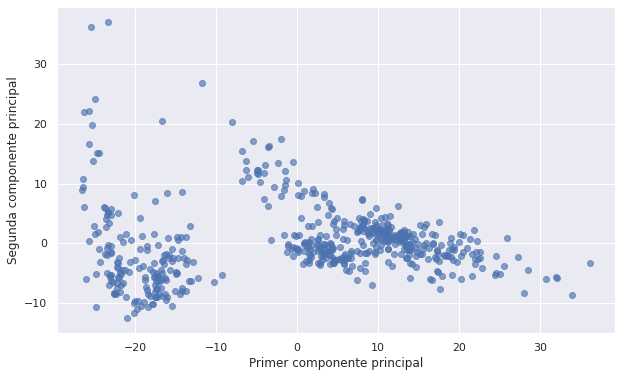

In [ ]:
df = pd.read_csv(filename)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()
# A.0 PARA TRABAJAR CON PCA
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print("Cantidad de datos del lote de entrenamiento: {}\nCantidad de datos del lote de testing: {}".format(X_train_set.shape[0], X_test.shape[1]))
print(X_train_set.shape, y_train_set.shape, X_test.shape, y_test.shape)
# B. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=None) # Creamos variable pca para usarlo
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_train_set)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X_train_set)

# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)
pd.DataFrame(X_pca).to_csv("x_pca_a.csv")
print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)

std_scale.fit(X_train_set)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados

print('Dimensiones de la matriz en componentes principales: {}'.format(X_train_set.shape))
print('Dimensiones de la matriz en componentes principales: {}'.format(X_test.shape))

# C. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
print(len(X_train_set), len(y_train_set))
clfSVCL = SVC(kernel="linear", C=0.025, probability=True)
clfSVCL.fit(X_train_set, y_train_set) # entreno

# D. SCORE
score_svcl = clfSVCL.score(X_train_set, y_train_set) # evaluo
print('score SVC Lineal:', score_svcl,)

# E. Matriz confusion
from sklearn.metrics import confusion_matrix
ypred = clfSVCL.predict(X_test)
cm = confusion_matrix(ypred, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E. Matriz confusion normalizado
cm = confusion_matrix(ypred, y_test, normalize='true') # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E.Matriz confusion sensibilidad y especificidad
cm = confusion_matrix(ypred, y_test) 

def balanced_accuracy(cm):
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

metricas = balanced_accuracy(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

# F. con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

fig, ax = plt.subplots(figsize = (10, 6))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Cantidad de samples: 528
Cantidad de features: 989
Cantidad de datos del lote de entrenamiento: 422
Cantidad de datos del lote de testing: 988
(422, 988) (422,) (106, 988) (106,)
Dimensiones de la matriz en componentes principales: (422, 422)
[[-2.10029710e+01 -4.27406896e+00 -4.28707221e-01 ... -2.82263845e-01
   2.15739333e-02 -1.85962357e-15]
 [ 8.91258643e-01  1.32484945e+00 -1.61348611e+00 ... -1.13738422e-02
  -5.61627391e-02  1.03736464e-15]
 [ 6.74732608e+00 -3.31767934e+00 -1.98458644e+00 ...  6.75512667e-02
  -8.13522391e-02  2.17534324e-15]
 ...
 [-1.98337506e+01  8.76012693e+00  1.00480436e+01 ... -3.24177342e-01
  -1.29401628e-01 -1.05471187e-15]
 [-2.05672928e+01 -2.64716696e+00  1.10822985e+00 ... -1.55869222e-02
  -1.90281347e-01 -1.74860126e-15]
 [-1.98693324e+01  8.82297177e-01  4.84686693e+00 ...  1.76372923e-01
  -2.23053406e-01 -8.88178420e-16]]
Dimensiones de la matriz en componentes principales: (422, 988)
Dimensiones de la matriz en componentes principales: (106

Text(0, 0.5, 'Segunda componente principal')

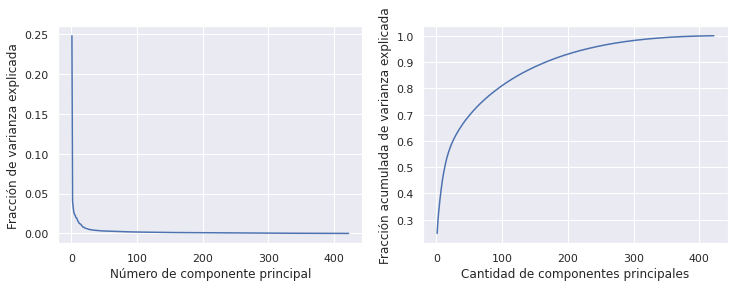

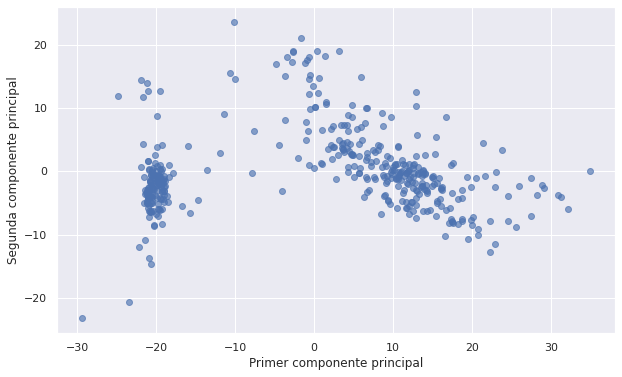

In [ ]:
df = pd.read_csv(filename1)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()
# A.0 PARA TRABAJAR CON PCA
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print("Cantidad de datos del lote de entrenamiento: {}\nCantidad de datos del lote de testing: {}".format(X_train_set.shape[0], X_test.shape[1]))
print(X_train_set.shape, y_train_set.shape, X_test.shape, y_test.shape)
# B. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=None) # Creamos variable pca para usarlo
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_train_set)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X_train_set)

# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)
pd.DataFrame(X_pca).to_csv("x_pca_b.csv")
print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)

std_scale.fit(X_train_set)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados

print('Dimensiones de la matriz en componentes principales: {}'.format(X_train_set.shape))
print('Dimensiones de la matriz en componentes principales: {}'.format(X_test.shape))

# C. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
print(len(X_train_set), len(y_train_set))
clfSVCL = SVC(kernel="linear", C=0.025, probability=True)
clfSVCL.fit(X_train_set, y_train_set) # entreno

# D. SCORE
score_svcl = clfSVCL.score(X_train_set, y_train_set) # evaluo
print('score SVC Lineal:', score_svcl,)

# E. Matriz confusion
from sklearn.metrics import confusion_matrix
ypred = clfSVCL.predict(X_test)
cm = confusion_matrix(ypred, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E. Matriz confusion normalizado
cm = confusion_matrix(ypred, y_test, normalize='true') # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E.Matriz confusion sensibilidad y especificidad
cm = confusion_matrix(ypred, y_test) 

def balanced_accuracy(cm):
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

metricas = balanced_accuracy(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

# F. con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

fig, ax = plt.subplots(figsize = (10, 6))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Cantidad de samples: 597
Cantidad de features: 989
Cantidad de datos del lote de entrenamiento: 477
Cantidad de datos del lote de testing: 988
(477, 988) (477,) (120, 988) (120,)
Dimensiones de la matriz en componentes principales: (477, 477)
[[-8.91018007e+00 -3.55726926e+00 -2.40531650e+00 ...  5.15619815e-02
  -1.31697568e-01  1.44328993e-15]
 [ 7.77536849e+00 -1.01934409e+01  7.65084166e-01 ... -7.16593664e-02
   1.19013437e-01  2.02615702e-15]
 [ 6.94481019e+00  2.73767964e+01 -3.32120045e+00 ...  2.52802520e-01
   1.31489333e-02  5.37764278e-16]
 ...
 [ 1.59069503e+01 -2.34947092e+00 -3.32221910e+00 ... -1.08853532e-01
  -3.61531590e-01 -1.63757896e-15]
 [ 5.72141572e+00 -1.03110461e+01  1.70968403e+00 ...  1.40172570e-01
  -7.41746573e-02 -2.22044605e-16]
 [ 1.52126519e+01 -1.66303807e+00 -4.30065450e+00 ... -3.10715632e-01
  -4.67927529e-01  9.99200722e-16]]
Dimensiones de la matriz en componentes principales: (477, 988)
Dimensiones de la matriz en componentes principales: (120

Text(0, 0.5, 'Segunda componente principal')

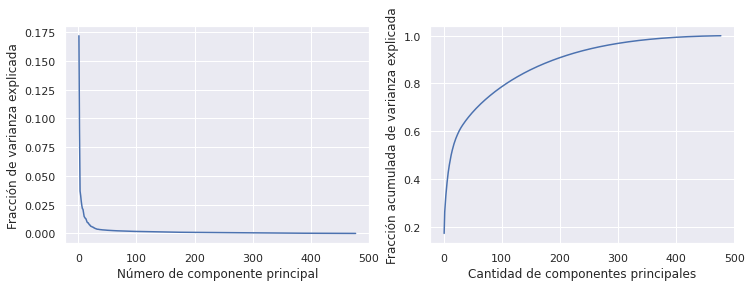

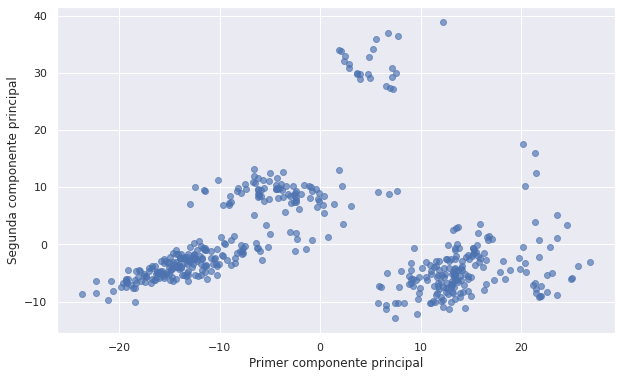

In [ ]:
df = pd.read_csv(filename2)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()
# A.0 PARA TRABAJAR CON PCA
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print("Cantidad de datos del lote de entrenamiento: {}\nCantidad de datos del lote de testing: {}".format(X_train_set.shape[0], X_test.shape[1]))
print(X_train_set.shape, y_train_set.shape, X_test.shape, y_test.shape)
# B. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=None) # Creamos variable pca para usarlo
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_train_set)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X_train_set)

# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)
pd.DataFrame(X_pca).to_csv("x_pca_c.csv")
print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)

std_scale.fit(X_train_set)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados

print('Dimensiones de la matriz en componentes principales: {}'.format(X_train_set.shape))
print('Dimensiones de la matriz en componentes principales: {}'.format(X_test.shape))

# C. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
print(len(X_train_set), len(y_train_set))
clfSVCL = SVC(kernel="linear", C=0.025, probability=True)
clfSVCL.fit(X_train_set, y_train_set) # entreno

# D. SCORE
score_svcl = clfSVCL.score(X_train_set, y_train_set) # evaluo
print('score SVC Lineal:', score_svcl,)

# E. Matriz confusion
from sklearn.metrics import confusion_matrix
ypred = clfSVCL.predict(X_test)
cm = confusion_matrix(ypred, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E. Matriz confusion normalizado
cm = confusion_matrix(ypred, y_test, normalize='true') # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E.Matriz confusion sensibilidad y especificidad
cm = confusion_matrix(ypred, y_test) 

def balanced_accuracy(cm):
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

metricas = balanced_accuracy(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

# F. con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

fig, ax = plt.subplots(figsize = (10, 6))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Cantidad de samples: 555
Cantidad de features: 989
Cantidad de datos del lote de entrenamiento: 444
Cantidad de datos del lote de testing: 988
(444, 988) (444,) (111, 988) (111,)
Dimensiones de la matriz en componentes principales: (444, 444)
[[ 2.20987958e+01  6.53189905e-01 -4.04517725e+00 ...  4.18013327e-02
   6.07567919e-02  8.04911693e-16]
 [ 5.06224558e+00  8.53622459e-02 -3.87357820e+00 ... -8.23827666e-02
  -2.58786264e-02 -6.66133815e-16]
 [-7.94155291e+00 -1.13183142e+01  3.10259957e+00 ... -6.29573400e-02
  -3.08975960e-01 -1.60982339e-15]
 ...
 [-1.27617379e+01 -3.95382708e+00  9.57221275e-01 ... -3.77411858e-01
   2.83236739e-01  4.71844785e-16]
 [ 1.25541016e+01  4.70414323e+00 -4.89828156e+00 ... -2.47834803e-01
   2.73792385e-02  7.63278329e-16]
 [ 2.06758211e+01  8.48207990e-01 -5.78782893e+00 ... -7.89508915e-03
  -3.38027423e-02  1.49880108e-15]]
Dimensiones de la matriz en componentes principales: (444, 988)
Dimensiones de la matriz en componentes principales: (111

Text(0, 0.5, 'Segunda componente principal')

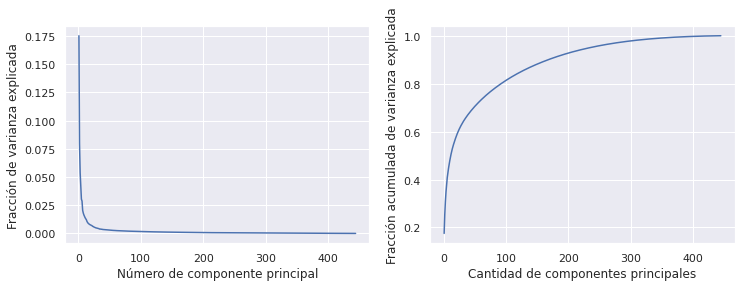

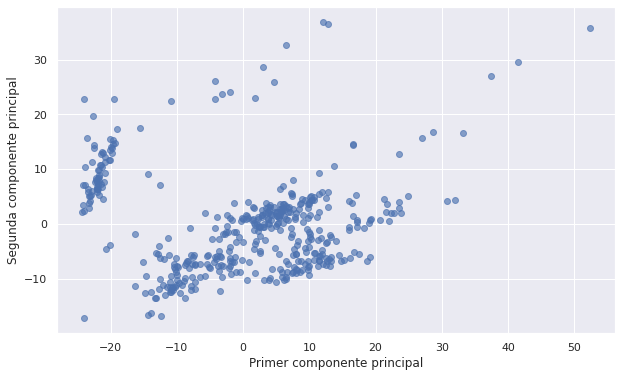

In [ ]:
df = pd.read_csv(filename3)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()
# A.0 PARA TRABAJAR CON PCA
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print("Cantidad de datos del lote de entrenamiento: {}\nCantidad de datos del lote de testing: {}".format(X_train_set.shape[0], X_test.shape[1]))
print(X_train_set.shape, y_train_set.shape, X_test.shape, y_test.shape)
# B. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=None) # Creamos variable pca para usarlo
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_train_set)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X_train_set)

# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)
pd.DataFrame(X_pca).to_csv("x_pca_d.csv")
print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)

std_scale.fit(X_train_set)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados

print('Dimensiones de la matriz en componentes principales: {}'.format(X_train_set.shape))
print('Dimensiones de la matriz en componentes principales: {}'.format(X_test.shape))

# C. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
print(len(X_train_set), len(y_train_set))
clfSVCL = SVC(kernel="linear", C=0.025, probability=True)
clfSVCL.fit(X_train_set, y_train_set) # entreno

# D. SCORE
score_svcl = clfSVCL.score(X_train_set, y_train_set) # evaluo
print('score SVC Lineal:', score_svcl,)

# E. Matriz confusion
from sklearn.metrics import confusion_matrix
ypred = clfSVCL.predict(X_test)
cm = confusion_matrix(ypred, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E. Matriz confusion normalizado
cm = confusion_matrix(ypred, y_test, normalize='true') # primera entrada son las etiquetas predichas, segunda son las reales
print(cm)

# E.Matriz confusion sensibilidad y especificidad
cm = confusion_matrix(ypred, y_test) 

def balanced_accuracy(cm):
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

metricas = balanced_accuracy(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

# F. con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

fig, ax = plt.subplots(figsize = (10, 6))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

In [ ]:
# Matriz de features en el espacio de componentes principales
# Simplemente la matriz traspuesta de las componentes principales en el espacio de features
features_pc = pca.components_.T

print('Descripción de la variable M2 en las componentes principales:')
print(features_pc[0])

In [ ]:
df = pd.read_csv(filename3)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()
# A.0 PARA TRABAJAR CON PCA
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print("Cantidad de datos del lote de entrenamiento: {}\nCantidad de datos del lote de testing: {}".format(X_train_set.shape[0], X_test.shape[1]))
print(X_train_set.shape, y_train_set.shape, X_test.shape, y_test.shape)
# B. CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=None) # Creamos variable pca para usarlo
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_train_set)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X_train_set)

# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)
print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)

std_scale.fit(X_train_set)#Grafica parte 2 SVC

In [99]:
def grafics(df1):
 X1 = df1[:,:2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
 h = .02  # step size in the mesh
 y = y_train_set
 # we create an instance of SVM and fit out data. We do not scale our
 # data since we want to plot the support vectors
 C = 1.0  # SVM regularization parameter
 svc = SVC(kernel='linear', C=C).fit(X1, y)
 rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X1, y)

 # create a mesh to plot in
 x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
 y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
 xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

 # title for the plots
 titles = ['SVC with linear kernel',
          'SVC with RBF kernel']


 for i, clf in enumerate((svc, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()

In [100]:
df1 = X_scaled

In [102]:
print(df1, y_train_set)

[[ 0.06754023 -0.77302545 -0.11544437 ...  1.03552436  1.39418617
   0.48310729]
 [-0.56343994 -0.4994526  -0.01503004 ...  0.62045588 -0.02841894
  -0.63667546]
 [ 0.12307433 -0.87132854 -0.13508692 ... -0.12289585  0.30415869
  -0.01323576]
 ...
 [ 0.08515887 -0.82589126 -0.96131375 ... -0.51429363 -0.66964053
  -0.42610397]
 [ 0.32064312  0.44833494 -0.16451572 ... -0.12981194  0.14027277
   0.12215787]
 [-0.11632566  0.07622302 -0.14330686 ...  1.18910702  0.22234091
  -0.276376  ]] 518    1.0
438    0.0
89     1.0
411    2.0
406    1.0
      ... 
476    2.0
86     0.0
54     1.0
428    0.0
247    1.0
Name: Label, Length: 444, dtype: float64


TypeError: ignored

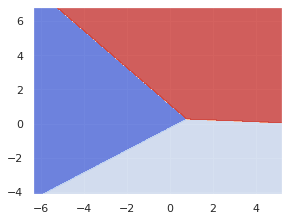

In [103]:
grafics(df1)

In [64]:
#Grafica parte 1 SVC
X1 = X_train_set.iloc[:,:2].values  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
h = .02  # step size in the mesh
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
# create a mesh to plot in
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
print(x_min, x_max)

-36.2249453125 68.73239299610893


In [65]:
#Grafica parte 3 SVC
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [ ]:

# title for the plots
titles = ['SVC with linear kernel']

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
plt.plot(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

clf =SVC(kernel='poly',degree=4)
#clf =SVC(kernel='linear')
#clf=SVC()
clf.fit(X_train_set, y_train_set)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(X_test, y_test)
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
 extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
 origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
 linetypes='--')
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired)
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.title('Kernelinomio grado 4')
plt.show()



In [ ]:

# title for the plots
titles = ['SVC with linear kernel']

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
plt.plot(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

clf =SVC(kernel='poly',degree=4)
#clf =SVC(kernel='linear')
#clf=SVC()
clf.fit(X_train_set, y_train_set)

# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
clfSVCL = SVC(kernel="linear", C=0.025, probability=True)
clfSVCL.fit(X_train_set, y_train_set)
Z = clfSVCL.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title(titles[i])

plt.show()

In [ ]:
X = df_train

print(X.count)
y = df_train['Label']

<bound method DataFrame.count of      lag1_mean_0  lag1_mean_1  lag1_mean_2  ...  freq_750_3  Label  Label
439    15.069980    40.658953    53.096797  ...    0.001720    2.0    2.0
286    27.276965    28.869625    28.553035  ...    0.005911    1.0    1.0
546    24.764996    27.250289    23.519523  ...    0.006359    0.0    0.0
299    25.135035    35.316500  -192.665090  ...    0.001017    2.0    2.0
256    26.063941    28.051371    26.355738  ...    0.004734    1.0    1.0
..           ...          ...          ...  ...         ...    ...    ...
551     8.663172    20.397246    26.346227  ...    0.013867    0.0    0.0
403    24.347313    27.894961    28.387047  ...    0.016875    1.0    1.0
507    23.790367    23.151422    39.926504  ...    0.027284    1.0    1.0
487    23.593891    18.650070    26.950863  ...    0.014333    0.0    0.0
429    20.248434    16.609219    26.851680  ...    0.018744    1.0    1.0

[546 rows x 990 columns]>


Modelo KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def experimentacion_feature_selection(df_train, correlaciones_a_testeear):
  scores_test = []
  # otro vector con otra metrica 
  X = df_train.iloc[:, :-1]
  print(X.shape)
  y = df_train['Label']
  neigh = KNeighborsClassifier(n_neighbors=3)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
  # cross validation
  for correlacion_corte in correlaciones_a_testeear:
    print(correlacion_corte)
    columns = select_k_best_correlated_features(df_train, correlacion_corte, absolute=True)
    columns = columns.index.to_list()
    X_train_fit = X_train[columns]
    X_test_fit = X_test[columns]
    neigh.fit(X_train_fit, y_train)
    scores_test.append(neigh.score(X_test_fit, y_test))
    # agregar valor de otra metrica
  return scores_test #, 

In [ ]:
corr_cut_exp = np.arange(start=0.1, step=0.1, stop=0.5)
experimentacion_feature_selection(df_train, corr_cut_exp)

(546, 988)
0.1
0.2
0.30000000000000004
0.4


[0.9727272727272728,
 0.9727272727272728,
 0.9636363636363636,
 0.9272727272727272]

In [ ]:
X = df_train.iloc[:, :-1]
X

lag1_mean_0  lag1_mean_1  lag1_mean_2  ...  freq_740_3  freq_750_3  Label
439    15.069980    40.658953    53.096797  ...    0.003374    0.001720    2.0
286    27.276965    28.869625    28.553035  ...    0.004569    0.005911    1.0
546    24.764996    27.250289    23.519523  ...    0.005731    0.006359    0.0
299    25.135035    35.316500  -192.665090  ...    0.001367    0.001017    2.0
256    26.063941    28.051371    26.355738  ...    0.015875    0.004734    1.0
..           ...          ...          ...  ...         ...         ...    ...
551     8.663172    20.397246    26.346227  ...    0.008770    0.013867    0.0
403    24.347313    27.894961    28.387047  ...    0.021768    0.016875    1.0
507    23.790367    23.151422    39.926504  ...    0.012296    0.027284    1.0
487    23.593891    18.650070    26.950863  ...    0.007993    0.014333    0.0
429    20.248434    16.609219    26.851680  ...    0.019347    0.018744    1.0

[546 rows x 989 columns]

In [ ]:
defskf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
defskf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)

In [ ]:
corr_cut_exp

array([0.1, 0.2, 0.3, 0.4])

In [ ]:
X = df_train.iloc[:, :-1]

In [ ]:
len(df_train.columns)

990

Random Forest

In [ ]:
# Creamos el clasificador con un máximo de 5 hojas
dtc = DecisionTreeClassifier(max_leaf_nodes = 5)

In [ ]:
# Entrenamiento del modelo
dtc.fit(X_train, y_train)

# Score del modelo en el conjunto de entrenamiento 
score_in_train = dtc.score(X_train, y_train)

# Score del modelo en el conjunto de testeo
score_in_test = dtc.score(X_test, y_test)

print('Score en el set de entrenamiento: {}'.format(score_in_train))
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de entrenamiento: 1.0
Score en el set de testeo: 1.0


In [ ]:
# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización 
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtc, feature_names, fontsize = 12, filled = True, ax = ax)

Comparaciòn de los clasificadores

In [ ]:
names = ["KNN", "SVM lineal", "SVM RBF", "Árbol de decisión", "Random Forest", "Red neuronal"]

classifiers = [
    KNeighborsClassifier(7),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),

In [ ]:
figure = plt.figure(figsize=(20, 8)) # armamos la figura

h = 0.02 # el paso de la grilla

for n in np.arange(len(datasets)): # itero n=0,1, 2 


    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # defino el rango de ejes x
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # defino el rango de ejes y
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h)) # construyo una mella de puntos en ese rango
    
    cm = plt.cm.RdBu # esto seleccion el tipo de color map (rojo-azul)
    cm_bright = ListedColormap(['#FF0000', '#0000FF']) # construye el colormap entre esos dos colores
    ax = plt.subplot(len(datasets), len(classifiers) + 1, 1+n*(len(classifiers)+1)) # ubica al comienzo de cada fila los scatter plot de los datos de entrenamiento
    
    ax.set_title("Input data") # titulo del subplot
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k') # plotea datos de entrenamiento
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
                  edgecolors='k') # plotea datos de evaluacion
    ax.set_xlim(xx.min(), xx.max()) # pone limites 
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    for k in np.arange(len(classifiers)): # este segundo plot recorre clasificadores
        
        name = names[k]  # nombre
        clf = classifiers[k] # objeto de clasificador
        clf.fit(X_train, y_train) # entreno
        score = clf.score(X_test, y_test) # evaluo
        
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predice las probabilidades sobre cada par de puntos de la grilla
        Z = Z.reshape(xx.shape) # le da el formato adecuado para plotear el mapa de colores
        
        ax = plt.subplot(len(datasets), len(classifiers) + 1, 1+n*(len(classifiers)+1)+k+1)
        
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8) # plotea el mapa de colores
    
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k') # plotea puntos de entrenamiento

        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6) # plotea puntos de evaluacion
    
        ax.set_xlim(xx.min(), xx.max()) # rango en x
        ax.set_ylim(yy.min(), yy.max()) # rango en y
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name) # pone titulo
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    
    